# Question 1.e

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

torch.set_printoptions(precision=10)
torch.__version__

'0.3.1.post2'

## Load train and test dataset

In [2]:
class OccupancyDataset(Dataset):
    """ Occupancy detection dataset"""
    
    def __init__(self, filename):
        self.dataset = np.loadtxt(filename, skiprows=1, dtype = object, delimiter=',')
        
        self.data = np.array(self.dataset[:,2:7], dtype = float)
        self.data = (self.data - self.data.mean())/self.data.std()
        self.data = torch.from_numpy(self.data).float()
        
        self.target = np.array(self.dataset[:,7], dtype = float)
        self.target = torch.from_numpy(self.target).float()
        
    def __len__(self):
        return self.data.size()[0]
    
    def __getitem__(self, idx):
        return (self.data[idx, :], self.target[idx])

    
# Setup datasets and loaders
train_dataset = OccupancyDataset('train_data.txt')
test_dataset = OccupancyDataset('test_data.txt')

train_batch_size = 100
test_batch_size = 100

train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size= test_batch_size, shuffle = False)

## Create network class

In [3]:
class Net(nn.Module):
    """ Neural network with 1 hidden layer and sigmoid activations """
    
    def __init__(self, h):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5,h)
        self.fc2 = nn.Linear(h,1)
        
    def forward(self, x):
        #print(x)
        x = F.sigmoid(self.fc1(x))
        return F.sigmoid(self.fc2(x))
 

## Setting variables

In [4]:
epochs = 2000
lr = 0.001
criterion = nn.BCELoss()

## Train function

In [5]:
def train(epoch):
    # Train the network
    running_loss = 0
    count = 0
    for i, data in enumerate(train_loader, 0):
        optimizer.zero_grad()
        inputs, target = data
        inputs, target = Variable(inputs), Variable(target.float())
        output = net(inputs).squeeze()
        loss =  criterion(output, target)     
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        count +=1

    return running_loss/count
    
    
def get_acc(loader, dataset):
    # Get accuracy (%) for train/test
    correct = 0
    total = 0
    for i, data in enumerate(loader, 0):
        inputs, target = data
        inputs, target = Variable(inputs), Variable(target.float())
        output = net(inputs).squeeze()
        output = output>0.5
        correct += (target.data.cpu().numpy() == output.data.cpu().numpy()).sum()
        total += target.size(0)
    return 100*int(correct)/int(total)
    

In [7]:
hidden_units = [1, 2, 5, 10, 20]
train_accuracies = []
test_accuracies = []

for h in hidden_units:
    print('\nStarting training with h={0}'.format(h))
    net = Net(h)
    acc = []
    optimizer = optim.Adam(params = net.parameters(), lr=lr)
    # Run epochs and store necessary metrics
    for i in range(epochs):
        loss = train(i)
        train_acc = get_acc(train_loader, 'Train')
        acc.append(train_acc)
        test_acc = get_acc(test_loader, 'Test')
        #if i%100==0:
            #print('\n')
            #print('Loss after epoch {1}: {0}'.format(loss, i))
            #print('Train Accuracy: {0}'.format(train_acc))
            #print('Test Accuracy: {0}'.format(test_acc))

            # Stop training based on below condition
        if i>200 and acc[i]-acc[i-50] < 1e-2:
            print('H = {2} Reached local minima at epoch: {0} with test accuracy: {1}'.format(i, test_acc, h))
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            break
        if i+1 == epochs:
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            



Starting training with h=1
H = 1 Reached local minima at epoch: 201 with test accuracy: 98.28753076292043

Starting training with h=2
H = 2 Reached local minima at epoch: 201 with test accuracy: 98.12346185397867

Starting training with h=5
H = 5 Reached local minima at epoch: 201 with test accuracy: 97.56972928630024

Starting training with h=10
H = 10 Reached local minima at epoch: 201 with test accuracy: 97.23133716160787

Starting training with h=20
H = 20 Reached local minima at epoch: 201 with test accuracy: 97.22108285479902


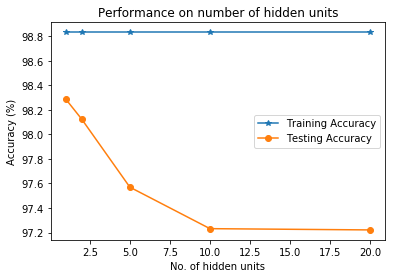

In [8]:
# Plot training error

plt.figure()
plt.title('Performance on number of hidden units')
plt.xlabel('No. of hidden units')
plt.ylabel('Accuracy (%)')
plt.plot(hidden_units, train_accuracies, '-*', label = 'Training Accuracy')

plt.plot(hidden_units, test_accuracies, '-o', label = 'Testing Accuracy')
plt.legend()


### Observations

- Increase in hidden units causes overfitting on MNIST dataset.
- As expected we see a decrease in test accuracy with increase in number of hidden units.